In [1]:
import numpy as np
import pandas as pd
from pycaret.classification import *
import datetime
import matplotlib.pyplot as plt
import glob 
import os 
from dotenv import load_dotenv
load_dotenv()

test_start = '2023-01-01'
fix = 513
# data_1_size = 2365     ###### 测试数据行数  ###############

part = os.getenv('part')
dir = f'c:/Users/shen_/Code/dragon/GA_Shane/outputs/{part}/'
os.chdir(dir)
os.makedirs('./temp',exist_ok=True)

train_path = glob.glob(os.path.join(dir,f'*_Train_{fix}_*.csv'))[0]
test_path = glob.glob(os.path.join(dir,f'*_Test_{fix}_*_PCA.csv'))[0]

data_1_size = int(test_path.split('_')[-2])
assert str(data_1_size) in test_path
print('data_1_size: ',data_1_size)

dataset_s = pd.read_csv(train_path)   ############# 训练集文件 ####################
dataset = dataset_s

num_xunlian = len(dataset_s)

# dataset.replace([np.inf, -np.inf], np.nan, inplace=True)   ####替换正负inf为NA


m_size = 25     ####### 测试多少个月 #######
buy = 1     ##### 多 ###################
sell = 0     ##### 空 ####################
rrr = 0.25     ###### 系数 ###################
m = 1000     ###### 总资金 ###################

print(train_path)
print(test_path)

assert len(dataset['A0'].unique()) > 1

dataset.tail()

data_1_size:  2300
c:/Users/shen_/Code/dragon/GA_Shane/outputs/20250424_003413_oMFt2l\RB99_1m_output_axis.csv_Train_513_16612.csv
c:/Users/shen_/Code/dragon/GA_Shane/outputs/20250424_003413_oMFt2l\RB99_1m_output_axis.csv_Test_513_2300_PCA.csv


,eob,A0,inside_bar_max_ret_close,high_+_close_diff_9,low_+_open_diff_9,close_+_low_diff_5,inside_bar_maxdd_close_cov_5,low_+_high_diff_9,h2l_mean_5,low_+_close_diff_1,...,spectral_entropy_open_interest_shift_30,high_+_close_diff_7_shift_30,close_+_low_diff_1_shift_30,open_interest_diff_7_shift_30,high_diff_1_shift_30,low_+_close_diff_3_shift_30,h2l_mean_3_shift_30,close_frac_shift_30,high_+_low_diff_1_shift_30,high_+_low_diff_3_shift_30
16607,2022-12-29 22:50:00,0.0,0.793315,0.630693,0.418130,1.177100,-0.427758,0.553459,-0.347353,0.956244,...,0.994194,-0.077372,1.451635,-0.352701,1.558944,1.077077,-0.389881,1.498342,1.490049,0.768999
16608,2022-12-29 22:59:00,0.0,-0.168096,0.521910,0.487439,1.126668,-0.366202,0.538286,-0.047384,-0.375765,...,0.698970,-0.090587,0.420743,-0.329056,0.062066,1.393027,-0.476091,-0.149519,0.694009,1.446997
16609,2022-12-30 10:09:00,0.0,0.773033,0.408599,0.352677,1.037020,-0.369511,0.388364,0.190816,0.541491,...,0.562489,0.235314,-0.022583,-0.230435,-0.256361,0.927899,-0.599489,0.304196,-0.313504,0.891143
16610,2022-12-30 13:43:00,0.0,0.941657,1.055341,0.787545,1.084079,-0.331725,0.942255,0.351368,1.098824,...,0.996181,0.560325,-0.204134,-0.900576,0.234678,0.097161,-0.377897,-0.009209,-0.028319,0.167622
16611,2022-12-30 14:53:00,0.0,-1.228448,1.252965,1.330342,0.854535,-0.318675,1.280500,0.111321,0.039850,...,-0.529489,0.627666,-0.002175,-0.783253,-0.277679,-0.115027,-0.860920,-0.129698,-0.035964,-0.180219


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import entropy

def information_gain_categorical_target(x, y, bins=10):
    """
    Calculate information gain for a categorical target (x) and continuous feature (y).
    Uses binning to discretize the continuous feature y.
    
    Args:
        x (pd.Series): Categorical target variable
        y (pd.Series): Continuous feature
        bins (int): Number of bins to discretize y
        
    Returns:
        float: Information gain
    """
    # Discretize continuous y into bins
    y_binned = pd.cut(y, bins=bins, labels=False)
    
    # Calculate entropy of the target
    H_x = entropy(x.value_counts(normalize=True), base=np.e)
    
    # Calculate conditional entropy H(X|Y)
    conditional_entropy = 0
    for y_val in y_binned.unique():
        x_subset = x[y_binned == y_val]
        if len(x_subset) > 0:
            p_y = len(x_subset) / len(x)
            H_x_given_y = entropy(x_subset.value_counts(normalize=True), base=np.e)
            conditional_entropy += p_y * H_x_given_y
    
    IG = H_x - conditional_entropy
    return IG


In [3]:
tmp_dataset = dataset_s[:int(len(dataset_s)*0.3)]

In [4]:

# Example usage
res = []
for col in tqdm(tmp_dataset.columns):
    if col == 'eob': continue
    if 'detrend' in col: continue
    x = tmp_dataset['A0']  # Target (should be categorical)
    y = tmp_dataset[col]   # Feature (continuous)
    
    ig = information_gain_categorical_target(x, y, bins=10)
    ic = np.corrcoef(tmp_dataset['A0'], tmp_dataset[col])[0, 1]
    
    res.append({'col': col, 'ig': ig, 'ic': ic})
res = pd.DataFrame(res)
res['abs_ic'] = res['ic'].abs()
res = res[[col for col in res.columns if col not in ['A0','A0_p']]]

100%|██████████| 638/638 [00:02<00:00, 258.24it/s]


In [5]:
res.describe()

,ig,ic,abs_ic
count,637.000000,637.000000,637.000000
mean,0.002890,0.006918,0.025813
std,0.026513,0.049050,0.042266
min,0.000203,-0.075145,0.000252
25%,0.001065,-0.015086,0.011675
50%,0.001615,0.005192,0.020499
75%,0.002398,0.029048,0.032679
max,0.670478,1.000000,1.000000


(0.0, 0.1)

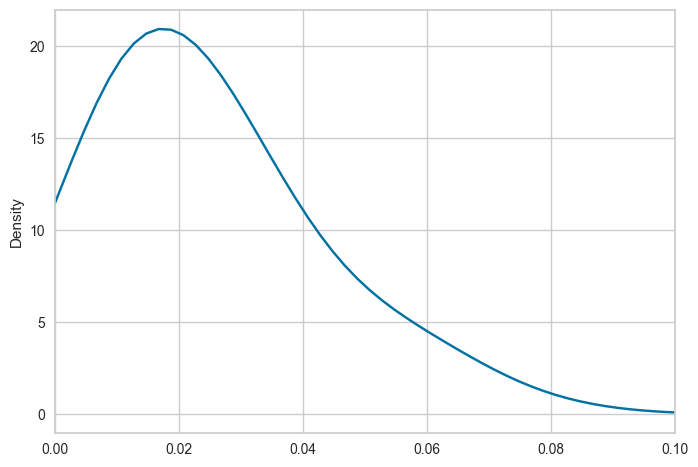

In [6]:
res['abs_ic'].plot(kind='kde')
plt.xlim(0,0.1)

In [7]:
res[res['col'].str.contains('inside_bar_sample')].sort_values('ic',key=abs)['abs_ic'].mean()
# res.sort_values('ic',key=abs).head(50)

0.020104858755976965

In [8]:
res.sort_values('ig',key=abs).to_csv('./features.csv')